In [176]:
from google.colab import drive
drive.mount('/content/drive')

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tqdm.keras import TqdmCallback # Cool progress bar instead of the lame line-by-line "progress bar" that comes by default with Keras.

print(tf.__version__)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# To suppress annoying warnings.
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.autograph.set_verbosity(0) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.7.0
Device mapping: no known devices.


# Data Loading

In [124]:
file_path = '/content/drive/My Drive/neural-network-learning/Datasets/lending_club_loan_two.csv'
df = pd.read_csv(file_path)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# EDA, Preprocessing

----
-----

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>LoanStatNew</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>loan_amnt</td>
      <td>The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.</td>
    </tr>
    <tr>
      <th>1</th>
      <td>term</td>
      <td>The number of payments on the loan. Values are in months and can be either 36 or 60.</td>
    </tr>
    <tr>
      <th>2</th>
      <td>int_rate</td>
      <td>Interest Rate on the loan</td>
    </tr>
    <tr>
      <th>3</th>
      <td>installment</td>
      <td>The monthly payment owed by the borrower if the loan originates.</td>
    </tr>
    <tr>
      <th>4</th>
      <td>grade</td>
      <td>LC assigned loan grade</td>
    </tr>
    <tr>
      <th>5</th>
      <td>sub_grade</td>
      <td>LC assigned loan subgrade</td>
    </tr>
    <tr>
      <th>6</th>
      <td>emp_title</td>
      <td>The job title supplied by the Borrower when applying for the loan.*</td>
    </tr>
    <tr>
      <th>7</th>
      <td>emp_length</td>
      <td>Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</td>
    </tr>
    <tr>
      <th>8</th>
      <td>home_ownership</td>
      <td>The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER</td>
    </tr>
    <tr>
      <th>9</th>
      <td>annual_inc</td>
      <td>The self-reported annual income provided by the borrower during registration.</td>
    </tr>
    <tr>
      <th>10</th>
      <td>verification_status</td>
      <td>Indicates if income was verified by LC, not verified, or if the income source was verified</td>
    </tr>
    <tr>
      <th>11</th>
      <td>issue_d</td>
      <td>The month which the loan was funded</td>
    </tr>
    <tr>
      <th>12</th>
      <td>loan_status</td>
      <td>Current status of the loan</td>
    </tr>
    <tr>
      <th>13</th>
      <td>purpose</td>
      <td>A category provided by the borrower for the loan request.</td>
    </tr>
    <tr>
      <th>14</th>
      <td>title</td>
      <td>The loan title provided by the borrower</td>
    </tr>
    <tr>
      <th>15</th>
      <td>zip_code</td>
      <td>The first 3 numbers of the zip code provided by the borrower in the loan application.</td>
    </tr>
    <tr>
      <th>16</th>
      <td>addr_state</td>
      <td>The state provided by the borrower in the loan application</td>
    </tr>
    <tr>
      <th>17</th>
      <td>dti</td>
      <td>A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.</td>
    </tr>
    <tr>
      <th>18</th>
      <td>earliest_cr_line</td>
      <td>The month the borrower's earliest reported credit line was opened</td>
    </tr>
    <tr>
      <th>19</th>
      <td>open_acc</td>
      <td>The number of open credit lines in the borrower's credit file.</td>
    </tr>
    <tr>
      <th>20</th>
      <td>pub_rec</td>
      <td>Number of derogatory public records</td>
    </tr>
    <tr>
      <th>21</th>
      <td>revol_bal</td>
      <td>Total credit revolving balance</td>
    </tr>
    <tr>
      <th>22</th>
      <td>revol_util</td>
      <td>Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.</td>
    </tr>
    <tr>
      <th>23</th>
      <td>total_acc</td>
      <td>The total number of credit lines currently in the borrower's credit file</td>
    </tr>
    <tr>
      <th>24</th>
      <td>initial_list_status</td>
      <td>The initial listing status of the loan. Possible values are – W, F</td>
    </tr>
    <tr>
      <th>25</th>
      <td>application_type</td>
      <td>Indicates whether the loan is an individual application or a joint application with two co-borrowers</td>
    </tr>
    <tr>
      <th>26</th>
      <td>mort_acc</td>
      <td>Number of mortgage accounts.</td>
    </tr>
    <tr>
      <th>27</th>
      <td>pub_rec_bankruptcies</td>
      <td>Number of public record bankruptcies</td>
    </tr>
  </tbody>
</table>

---
----

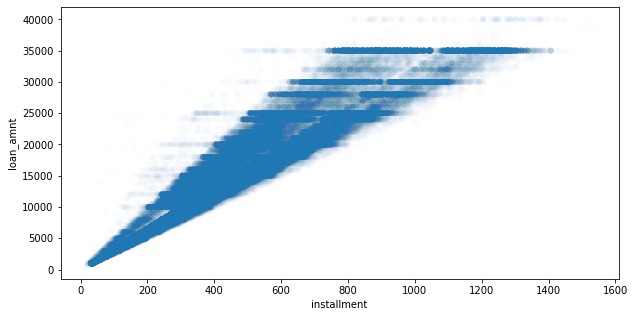

In [125]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='installment', y='loan_amnt', data=df, edgecolor='None', alpha=0.01);

In [126]:
df['term'] = df['term'].apply(lambda term: int(term[:3]))

In [127]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

In [128]:
df = df.drop(columns=['emp_title', 'emp_length', 'title', 'grade', 'issue_d', 'loan_status'], errors='ignore')

In [129]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [130]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [131]:
df = df.dropna()
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

In [132]:
subgrade_dummies = pd.get_dummies(df['sub_grade'], drop_first=True)
df = pd.concat([df.drop('sub_grade', axis=1), subgrade_dummies], axis=1)

In [133]:
dummies = pd.get_dummies(df[['verification_status', 'application_type', 'initial_list_status', 'purpose']], drop_first=True)
df = df.drop(['verification_status', 'application_type', 'initial_list_status', 'purpose'],axis=1)
df = pd.concat([df, dummies], axis=1)

In [134]:
df['home_ownership']=df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df = df.drop('home_ownership',axis=1)
df = pd.concat([df,dummies],axis=1)

In [135]:
df['zip_code'] = df['address'].apply(lambda address:address[-5:])

In [136]:
dummies = pd.get_dummies(df['zip_code'], drop_first=True)
df = df.drop(['zip_code', 'address'], axis=1)
df = pd.concat([df, dummies], axis=1)

In [137]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))
df = df.drop('earliest_cr_line', axis=1)

# Modelling

In [138]:
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [139]:
model = Sequential([
  Dense(78,  activation='relu'),
  Dropout(0.2),
  Dense(39, activation='relu'),
  Dropout(0.2),
  Dense(19, activation='relu'),
  Dropout(0.2),
  Dense(units=1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam')

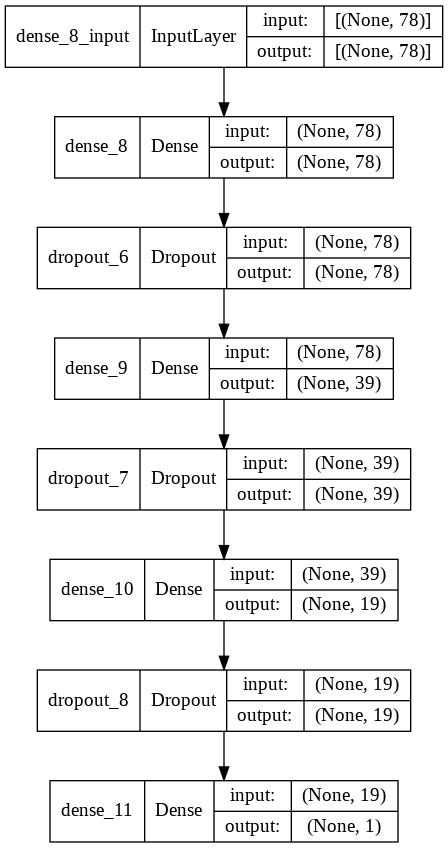

In [177]:
plot_model(model, show_shapes=True, show_layer_names=True)

0epoch [00:00, ?epoch/s]

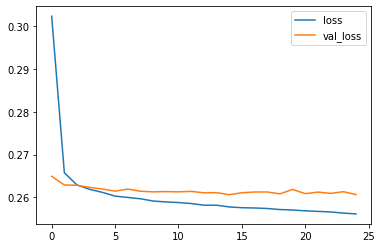

In [140]:
model.fit(
    X_train, 
    y_train, 
    epochs=25,
    batch_size=256,
    verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[TqdmCallback(verbose=0)]
);

pd.DataFrame(model.history.history).plot();

* For a multiclass classification use: `np.arg(model.predict,axis=1)`
* For a binary class classification use : `model.predict>0.5.astype('int32')`

In [175]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype('int32')

In [163]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.45      0.61     15658
           1       0.88      1.00      0.93     63386

    accuracy                           0.89     79044
   macro avg       0.92      0.72      0.77     79044
weighted avg       0.90      0.89      0.87     79044



In [165]:
confusion_matrix(y_test, predictions)

array([[ 7035,  8623],
       [  223, 63163]])

In [174]:
import random
random_idx = random.randint(0, len(df))
print('idx: ', random_idx)

new_customer = df.drop('loan_repaid', axis=1).iloc[random_idx]
model.predict(new_customer.values.reshape(1, 78))

idx:  244915


array([[1.]], dtype=float32)